In [177]:
import os 
import sys

import tensorflow as tf
from tensorflow.keras import layers
import cv2
from PIL import Image
from patchify import patchify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [302]:
# Constants
PATCH_SIZE = 256
CHANNELS = 3

In [303]:
directory = r'semantic_segmentation_dataset/'

def load_files(folder,file_type):
    """Function to crop and patch the images and masks
    Input:
        folder: string that corresponds to the folder's name 
        file_type: string that corresponds to the file type
    Output:
        A numpy array with all the images with sizes PATCH_SIZE x PATCH_SIZE x CHANNELS  
    """

    if folder == 'images':
        scaler = MinMaxScaler()
        tipo = np.float32
    else:
        tipo = np.int32      

    images = []
    for paths, folders, files in os.walk(directory):
        dirs = paths.split(os.path.sep)[-1]
        if dirs == folder:
            for file in files:
                if file.endswith(file_type):
                    image = cv2.imread(paths+'/'+str(file))
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                    y_size, x_size, _ = image.shape
                    x_size = (x_size // PATCH_SIZE) * PATCH_SIZE
                    y_size = (y_size // PATCH_SIZE) * PATCH_SIZE
                    image = Image.fromarray(image)
                    image = image.crop((0, 0, x_size, y_size))
                    image = np.array(image)

                    # Let us create patches from the different images
                    patchs = patchify(image, (PATCH_SIZE, PATCH_SIZE, CHANNELS), step=PATCH_SIZE)
                    y_size, x_size = patchs.shape[0], patchs.shape[1]
                    size = PATCH_SIZE*PATCH_SIZE
                    if tipo == np.float32: 
                        for i in range(y_size):
                            for j in range(x_size):
                                img = patchs[i,j,0,:,:,:]
                                img = scaler.fit_transform(img.reshape(size,-1)).reshape(PATCH_SIZE,PATCH_SIZE,-1)
                                images.append(img)
                    else:
                        for i in range(y_size):
                            for j in range(x_size):
                                img = patchs[i,j,0,:,:,:]
                                images.append(img)
    images = np.array(images, dtype=tipo)  
    return images

images = load_files('images','jpg')
masks = load_files('masks','png')
print(images.shape,masks.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


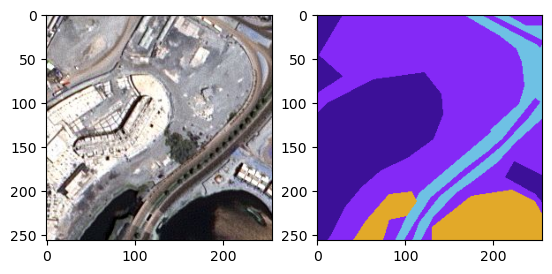

In [304]:
# Checking the images obtained
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[150,:,:,:])
ax[1].imshow(masks[150,:,:,:])
plt.show()

In [305]:
# Transforming Hex codes to RGB

""" Original HEX codes of the images from 
   https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
   1. Building: #3C1098
   2. Land (unpaved area): #8429F6
   3. Road: #6EC1E4
   4. Vegetation: #FEDD3A
   5. Water: #E2A929
   6. Unlabeled: #9B9B9B
"""
lista = [('Building','3C1098'),
   ('Land', '8429F6'),
   ('Road', '6EC1E4'),
   ('Vegetation', 'FEDD3A'),
   ('Water', 'E2A929'),
   ('Unlabeled', '9B9B9B')
]
# Getting the RGB values from HEX
dic = {}
n_classes = len(lista)
index = 0
for tuples in lista:
   val = tuples[1]
   dic[index] = np.array([int(val[i-2:i],16) for i in range(2,len(val)+1,2)])
   index += 1
print(dic)

{0: array([ 60,  16, 152]), 1: array([132,  41, 246]), 2: array([110, 193, 228]), 3: array([254, 221,  58]), 4: array([226, 169,  41]), 5: array([155, 155, 155])}


In [306]:
# Transforming the RGB values into categoricalones using onehot encoding

from keras.utils import to_categorical

# Replacing the RGB values by integers in masks
labeled_mask = []
keys = dic.keys()
for mask in masks:
    new_mask = np.zeros((PATCH_SIZE, PATCH_SIZE))
    for i in keys:
        new_mask[np.all(mask == dic[i], axis = -1)] = i 
    #print(np.unique(new_mask)) 
    labeled_mask.append(new_mask)

# Hot encoding the labels
labeled_mask = np.array(labeled_mask)
cat_masks = to_categorical(labeled_mask, num_classes= n_classes)  # categorical mask



In [309]:
# Splitting the images into train and test images
x_train, x_test, y_train, y_test = train_test_split(images, cat_masks, test_size = 0.1, random_state=43)  
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(1174, 256, 256, 3) (131, 256, 256, 3) (1174, 256, 256, 6) (131, 256, 256, 6)


In [310]:
def u_net_model(n_classes, HEIGHT=PATCH_SIZE, WIDTH=PATCH_SIZE, CHANNELS=CHANNELS):  
    """U-net model for semantic segmentation
    Input:
        n_classes: Integer. Number of categories in the classification problem
        HEIGHT, WIDTH, CHANNELS: Integers. Height, width and number of channels of given image
    Output:
        tensorflow model object    
    """

    f = [16, 32, 64, 128, 256, 512] 
    kernel_size = (3, 3)

    input = layers.Input((HEIGHT,WIDTH,CHANNELS))
    c1 = layers.Conv2D(f[0], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(input)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(f[0], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    mp1 = layers.MaxPooling2D(pool_size=(2,2))(c1)

    c2 = layers.Conv2D(f[1], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(mp1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(f[1], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    mp2 = layers.MaxPooling2D(pool_size=(2,2))(c2)

    c3 = layers.Conv2D(f[2], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(mp2)
    c3 = layers.Dropout(0.1)(c3)
    c3 = layers.Conv2D(f[2], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    mp3 = layers.MaxPooling2D(pool_size=(2,2))(c3)

    c4 = layers.Conv2D(f[3], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(mp3)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(f[3], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    mp4 = layers.MaxPooling2D(pool_size=(2,2))(c4)

    c5 = layers.Conv2D(f[4], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(mp4)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(f[4], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    c6 = layers.Conv2DTranspose(f[3], (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = layers.concatenate([c6,c4])
    c6 = layers.Conv2D(f[3], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = layers.Dropout(0.1)(c6)
    c6 = layers.Conv2D(f[3], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    c7 = layers.Conv2DTranspose(f[2], (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = layers.concatenate([c7,c3])
    c7 = layers.Conv2D(f[2], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(f[2], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    c8 = layers.Conv2DTranspose(f[1], (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = layers.concatenate([c8,c2])
    c8 = layers.Conv2D(f[1], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(f[1], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    c9 = layers.Conv2DTranspose(f[0], (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = layers.concatenate([c9,c1])
    c9 = layers.Conv2D(f[0], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(f[0], kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    output = layers.Conv2D(n_classes, (1,1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    return model

In [428]:
def jaccard(y_true, y_pred):
    """ Taylored Jaccard function (SIMRATIO)
    Input:
        y_true: tensorflow tensor. It contains the true values we want to approximate
        y_pred: tensorflow tensor. It contains the prediction values
    Output:
        float. Jaccard simmilarity    
    """
    size = PATCH_SIZE * PATCH_SIZE * len(y_true)
    y_pred = tf.reshape(y_pred, [size * n_classes])
    y_true = tf.reshape(y_true, [size * n_classes])
    # SIMRATIO
    intersection = tf.reduce_sum(tf.math.multiply(y_pred, y_true))
    diff = y_pred - y_true
    union = intersection + tf.reduce_sum(tf.math.multiply(diff, diff))
    return intersection / union 

In [429]:
# Model training
model = u_net_model(n_classes)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',jaccard],
              run_eagerly=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
]

results = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
74/74 [==============================] - 302s 4s/step - loss: 1.2217 - accuracy: 0.5207 - jaccard: 0.4328 - val_loss: 0.8598 - val_accuracy: 0.6876 - val_jaccard: 0.5785
Epoch 2/100
74/74 [==============================] - 361s 5s/step - loss: 0.8978 - accuracy: 0.6647 - jaccard: 0.5767 - val_loss: 0.7912 - val_accuracy: 0.7074 - val_jaccard: 0.6187
Epoch 3/100
74/74 [==============================] - 310s 4s/step - loss: 0.8216 - accuracy: 0.7018 - jaccard: 0.6080 - val_loss: 0.7186 - val_accuracy: 0.7475 - val_jaccard: 0.6469
Epoch 4/100
74/74 [==============================] - 289s 4s/step - loss: 0.8115 - accuracy: 0.7092 - jaccard: 0.6133 - val_loss: 0.7111 - val_accuracy: 0.7553 - val_jaccard: 0.6417
Epoch 5/100
74/74 [==============================] - 360s 5s/step - loss: 0.7520 - accuracy: 0.7314 - jaccard: 0.6393 - val_loss: 0.6551 - val_accuracy: 0.7720 - val_jaccard: 0.6663
Epoch 6/100
74/74 [==============================] - 271s 4s/step - loss: 0.7211 - accurac

In [183]:
# Model saving
model.save('u_net_semantic.h5')

In [445]:
def plot_figures(img_test, mask_test, img_pred, nn=5, seed=17):
    """Function to plot nn original images, nn original masks and nn predicted masks
        Input:
            img_test, mask_test, img_pred: numpy arrays. Array with the original images, 
            original masks and predicted masks respectively
            nn: integer. Number of images to compare (randomly chosen)
            seed: integer. Seed for the random generator
        Output:
            It plots the corresponding images    
    """
    seed = np.random.seed(seed)
    idxs = np.random.randint(0,len(img_test),nn)
    cmap = plt.cm.jet
    fig, ax = plt.subplots(nn,3,figsize=(50,50))
    n = 0
    for i in idxs:
        ax[0,0].set_title('Original_images',fontsize=20)
        ax[n,0].imshow(img_test[i])
        ax[0,1].set_title('Original_masks',fontsize=20)
        ax[n,1].imshow(mask_test[i])
        ax[0,2].set_title('Predicted_masks',fontsize=20)
        ax[n,2].imshow(img_pred[i])
        n += 1
    plt.show()

def image_hex_transf(vec,keys):
    """ Function to transform RGB images into HEX images
        Input: 
            vec: numpy array. Array with RGB images
            keys: dictionary. Dictionary whose keys are HEX codes 
            and its values are the corresponding RGB vector
        Output:
            numpy array. An array with HEX images
    """
    masks = tf.math.argmax(vec, axis=-1) # To transform into tensorflow tensor
    inv_masks = []
    for mask in masks:
        new_mask = np.zeros((PATCH_SIZE, PATCH_SIZE, CHANNELS))
        mask = np.array(mask).reshape((PATCH_SIZE, PATCH_SIZE, 1))
        for i in keys:
            new_mask[np.all(mask == i, axis = -1)] = dic[i]
        new_mask = np.array(new_mask, dtype=np.int32)  
        inv_masks.append(new_mask) 
    return np.array(inv_masks)     

In [431]:
# predicting the labels for each area
img_pred = model.predict(x_test)

5/5 [==============================] - 5s 983ms/step


In [443]:
# Transforming the RGB images into HEX images
y_test_2 = image_hex_transf(y_test, keys) 
img_pred_2 = image_hex_transf(img_pred, keys)

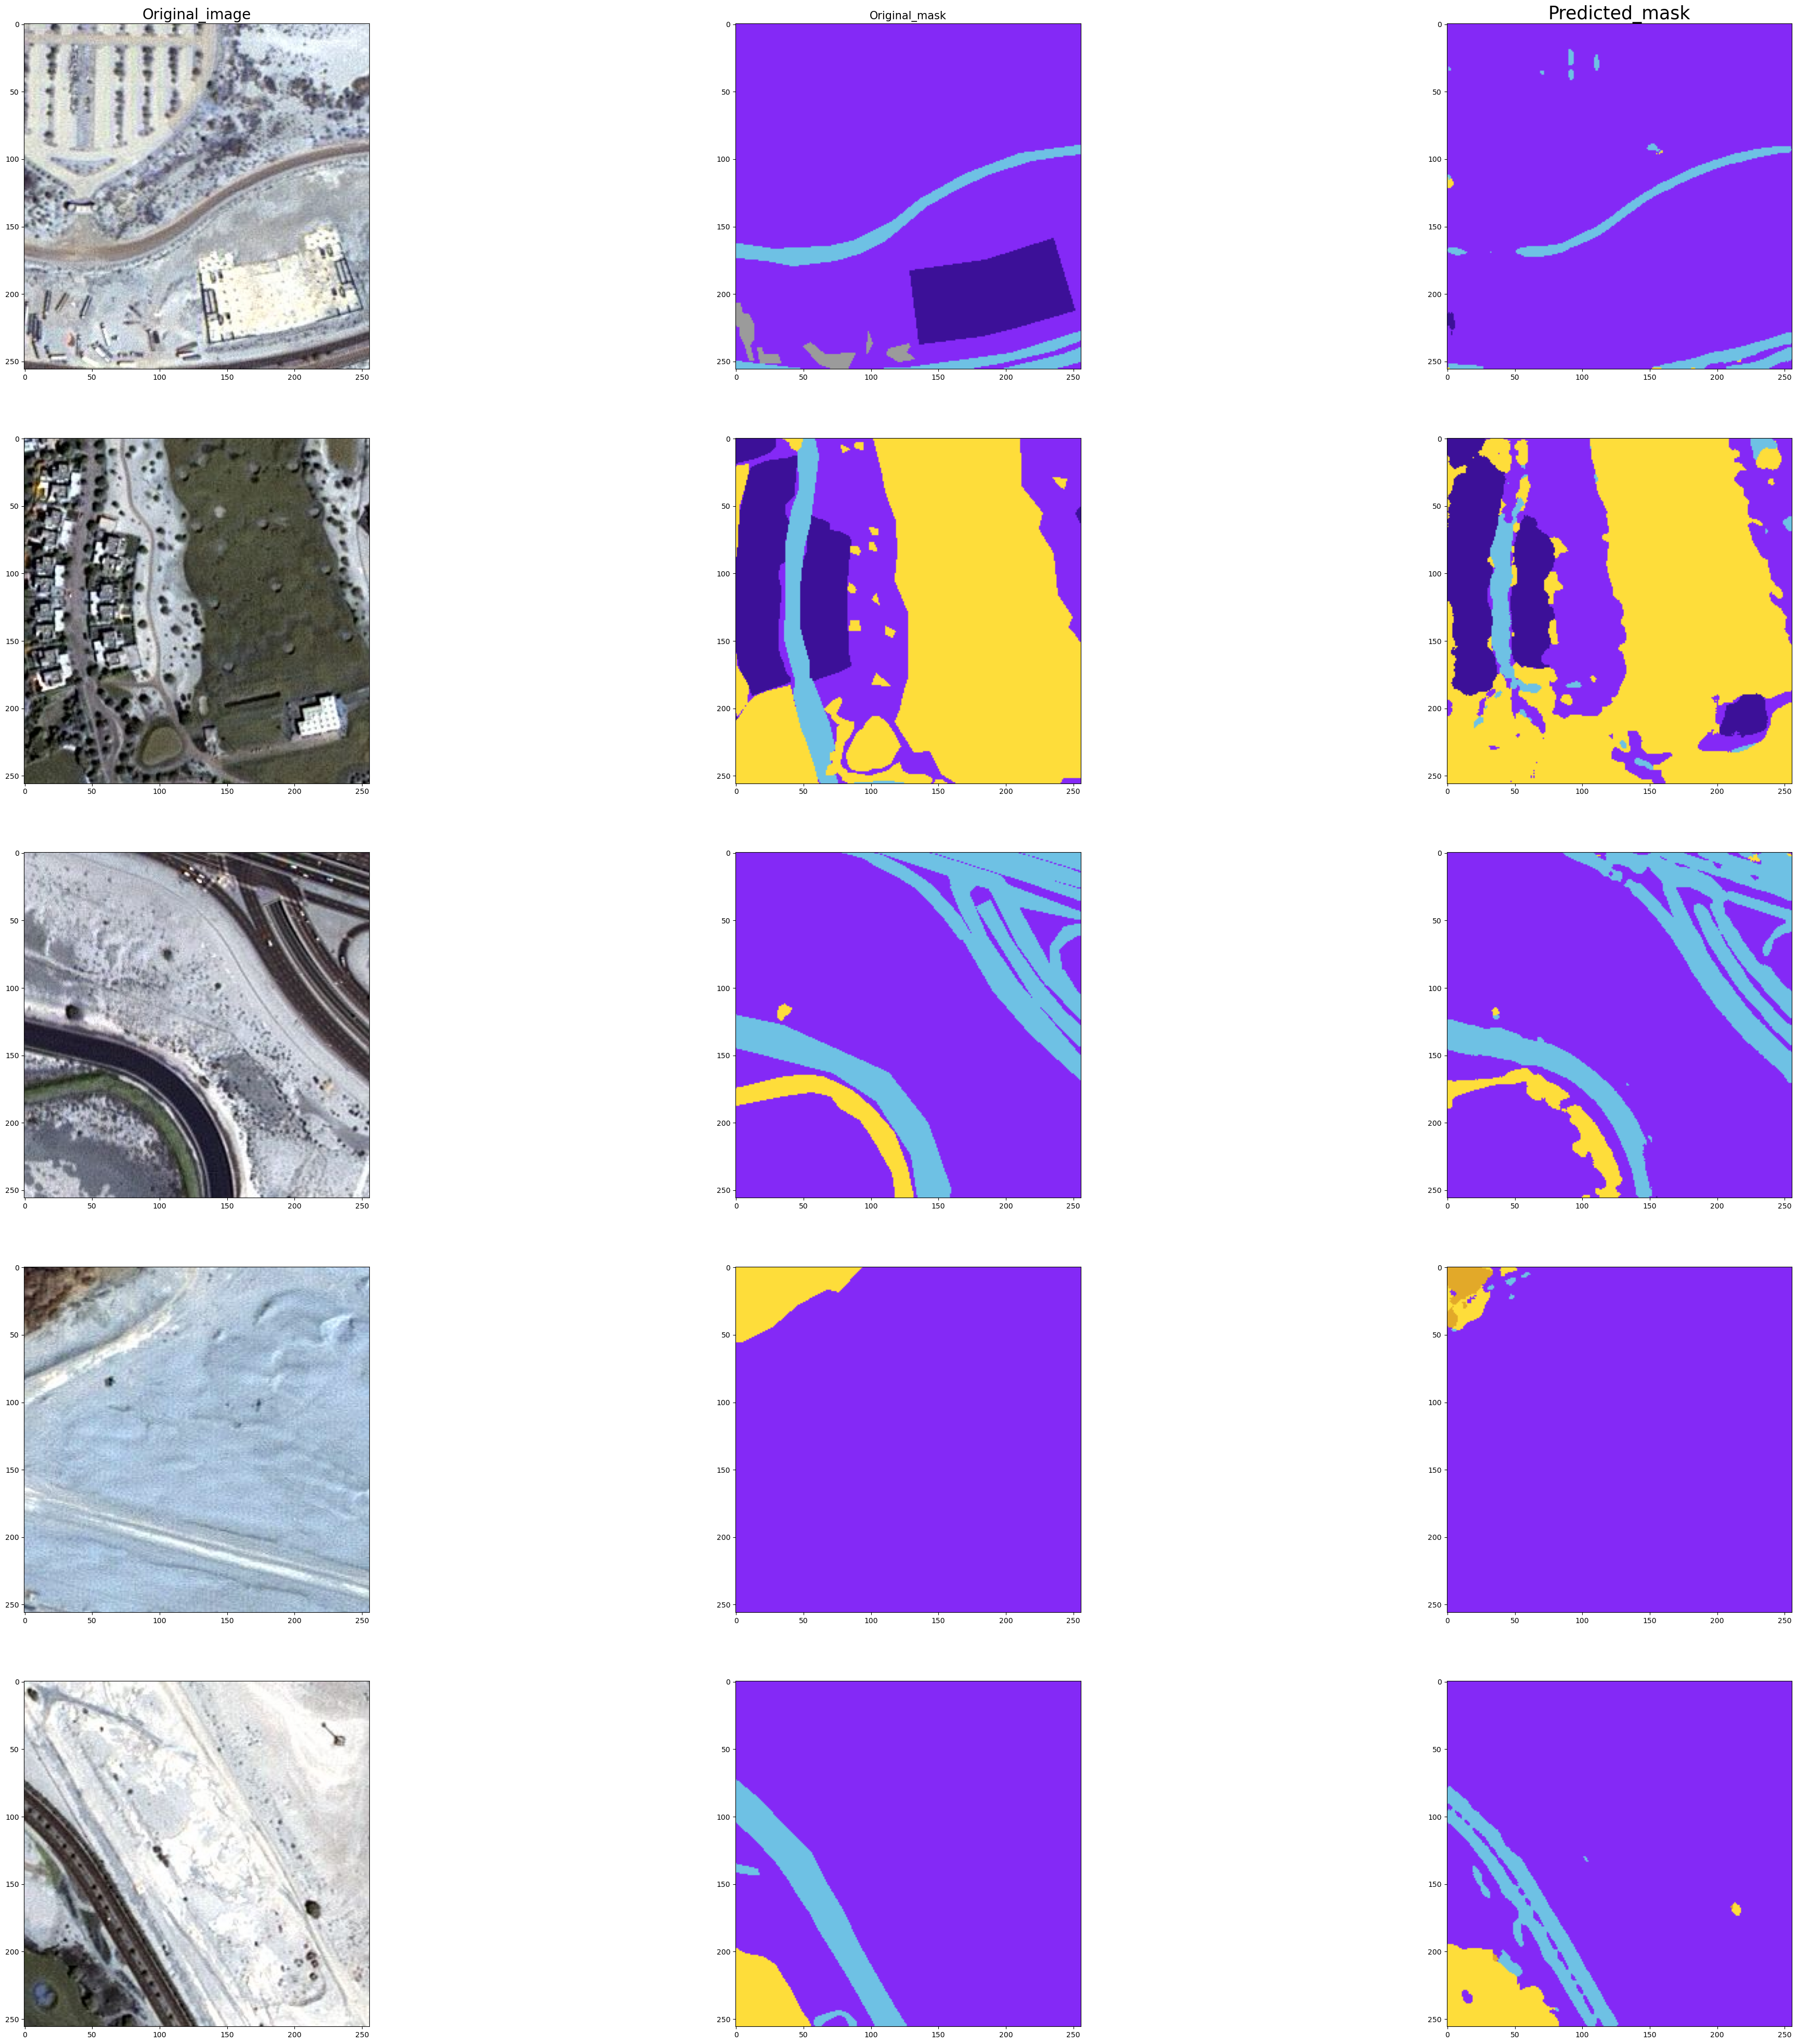

In [444]:
# Plotting results
plot_figures(x_test, y_test_2, img_pred_2,seed=10)